<a href="https://colab.research.google.com/github/jdarm128/Detecting-Spam-Emails-with-NLP/blob/main/Phishing_Email_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.1 DATASET COLLECTION

**Add files and download appropiate libraries:**

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving emails.csv to emails.csv


In [ ]:
import pandas as pd
df = pd.read_csv('emails.csv')
print(df.head())

                                                text  spam
0  Subject: naturally irresistible your corporate...     1
1  Subject: the stock trading gunslinger  fanny i...     1
2  Subject: unbelievable new homes made easy  im ...     1
3  Subject: 4 color printing special  request add...     1
4  Subject: do not have money , get software cds ...     1


# 2.2 DATA PRE-PROCESSING

**Clean the "Message" section of dataset:**

In [ ]:
import pandas as pd
import re
import nltk
nltk.download('punkt')
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv('emails.csv')

# Basic cleaning function
def clean_text(text):
    text = str(text)
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

df['Cleaned_Message'] = df['text'].apply(clean_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Vectorize, find TF-IDF, and tokenize the cleaned text:**

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'\b[a-zA-Z]{3,}\b')
#\b[a-zA-Z]{2,}\b filters out numbers and words shorter than 2 characters.

X_tfidf = vectorizer.fit_transform(df['Cleaned_Message'])

feature_names = vectorizer.get_feature_names_out()
print("Top 10 words:", feature_names[:10])


Top 10 words: ['aaa' 'aaaenerfax' 'aadedeji' 'aagrawal' 'aal' 'aaldous' 'aaliyah' 'aall'
 'aanalysis' 'aaron']


# 2.3 MODELING

**Import different machine learning models and apply to table:**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pandas as pd

# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['spam'], test_size=0.2, random_state=42)

# 2. Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', C=10, gamma=0.1, probability=True),
}

NameError: name 'X_tfidf' is not defined

# 2.4 MODEL EVALUATION

**Use Grid Search to find optimal settings for SVC**

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(probability=True), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)

**K-Fold Cross selection:**

In [ ]:
from sklearn.model_selection import cross_val_score

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} - Mean Accuracy: {scores.mean():.4f}")


KeyboardInterrupt: 

**Compare each model by creating a confusion matrix and a classification report:**

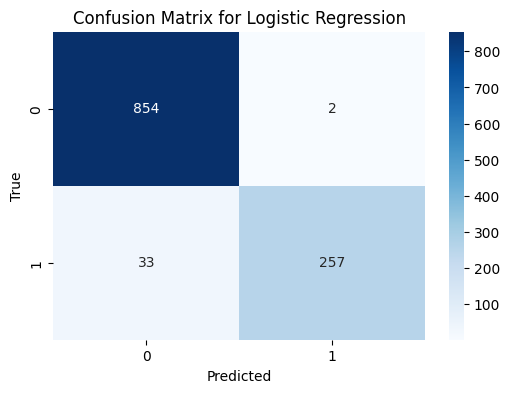

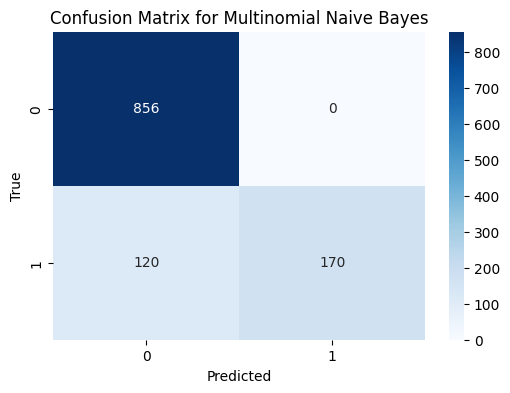

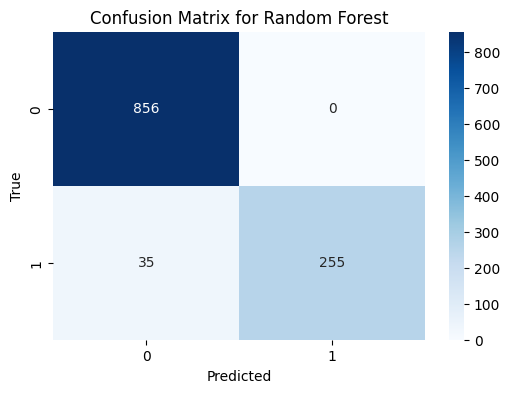

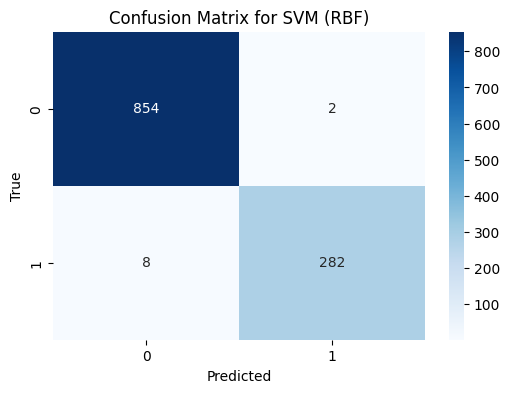

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
#### For confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
####

results= []
classification_reports = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    roc_auc = roc_auc_score(y_test, y_proba[:, 1], multi_class='ovr')

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average="weighted", zero_division=0),
        'Recall': recall_score(y_test, y_pred, average="weighted", zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, average="weighted", zero_division=0),
        'ROC-AUC': roc_auc
    })

    classification_reports[name] = classification_report(y_test, y_pred, zero_division=0)

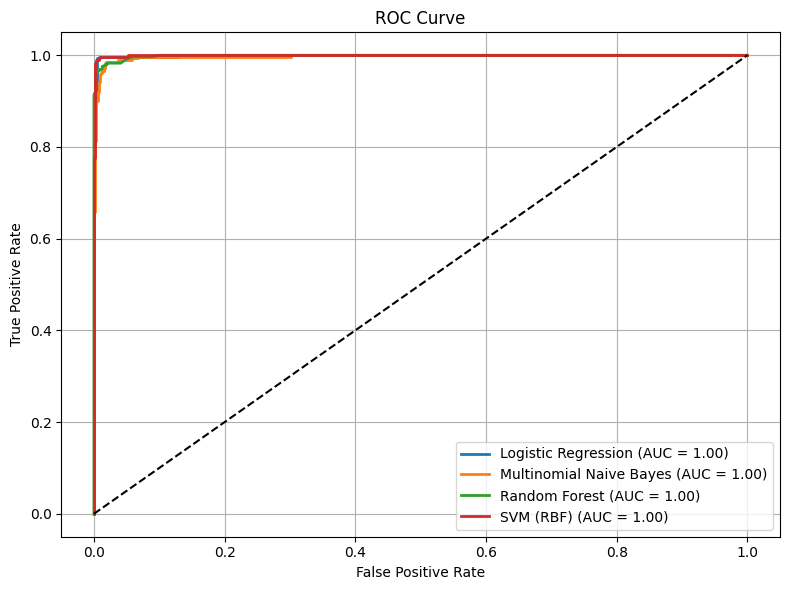

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))  # Bigger plot

for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()  # Shrinks margins
plt.show()


## Summary of Model Performance

Here's a table summarizing the performance of each model based on various evaluation metrics:

In [ ]:
print("Detailed Classification Reports:")
for name, report in classification_reports.items():
    print(f"\n{name}:\n{report}")

Detailed Classification Reports:

Logistic Regression:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       856
           1       0.99      0.89      0.94       290

    accuracy                           0.97      1146
   macro avg       0.98      0.94      0.96      1146
weighted avg       0.97      0.97      0.97      1146


Multinomial Naive Bayes:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       856
           1       1.00      0.59      0.74       290

    accuracy                           0.90      1146
   macro avg       0.94      0.79      0.84      1146
weighted avg       0.91      0.90      0.89      1146


Random Forest:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       856
           1       1.00      0.88      0.94       290

    accuracy                           0.97      1146
   macro avg       0.98      0.

Knowing SVM is the best model, we export and save the tf-idf and

In [ ]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', C=10, gamma=0.1, probability=True)
svm_model.fit(X_train, y_train)


SVC(C=10, gamma=0.1, kernel='linear', probability=True)

In [ ]:
import pickle

# Save the trained SVM model
with open("model.pkl", "wb") as f:
    pickle.dump(svm_model, f)

# Save the vectorizer
with open("tfidf.pkl", "wb") as f:
    pickle.dump(vectorizer, f)


In [ ]:
from google.colab import files

files.download("model.pkl")
files.download("tfidf.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# BERT (Deep Learning Implementation

In [ ]:
!pip install transformers datasets
!pip install -U transformers

In [ ]:
import pandas as pd

# Load
df = pd.read_csv('emails.csv')
df = df[['text', 'spam']]
df.columns = ['text', 'label']
df['label'] = df['label'].astype(int)
df.head()


,text,label
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [ ]:
from transformers import BertTokenizer
from datasets import Dataset

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

hf_dataset = Dataset.from_pandas(df)

def tokenize_function(example):
    return tokenizer(example['text'], padding="max_length", truncation=True, max_length=512)

tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/5728 [00:00<?, ? examples/s]

In [ ]:
split_dataset = tokenized_dataset.train_test_split(test_size=0.2)
train_ds = split_dataset['train']
test_ds = split_dataset['test']

from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2,device_map="cpu")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Define evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

# Training configuration
training_args = TrainingArguments(
    output_dir="./bert-spam-output",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    save_strategy="no",
    fp16=True
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

trainer.evaluate()

Step,Training Loss
500,0.001400


{'eval_loss': 0.032897744327783585,
 'eval_accuracy': 0.993891797556719,
 'eval_precision': 0.9783393501805054,
 'eval_recall': 0.9963235294117647,
 'eval_f1': 0.9872495446265938,
 'eval_runtime': 9.2972,
 'eval_samples_per_second': 123.263,
 'eval_steps_per_second': 7.744,
 'epoch': 3.0}

In [ ]:
model.save_pretrained("bert_model/")
tokenizer.save_pretrained("bert_model/")

('bert_model/tokenizer_config.json',
 'bert_model/special_tokens_map.json',
 'bert_model/vocab.txt',
 'bert_model/added_tokens.json')